<h1 style="text-align: center"> Licence Number Recognition with Yolo and EasyOCR</h1>

The License Number Recognition dataset consists of 433 images of cars. Labels are provided for the bounding boxes of license plates, but not for the plate number. The recognition problem will require two models: one for detection of license plates and one for recognition. Feeding the images as is into the recognition model without isolating the license plate will result in poor performance. This is because character recognition models are typically trained on chunks of text without background noise which is present in original images. The detection problem will be adressed with a Yolo model, originally Yolov7 was chosen for its exceptional combination of high speed and accuracy, however Yolov5 performs better on this particular dataset as will be shown later. The recognition problem is resolved with EasyOCR which was designed to read short texts such as license numbers. Unlike the Yolo models, EasyOCR cannot be transfer learnt on this particular dataset due to the absence of license number labels. 




In [ ]:
import os
import sys
os.chdir('/content/drive/MyDrive/Code/yolov7')
import shutil
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
from PIL import Image
import glob
import cv2
import yaml
import pandas as pd
import os
from matplotlib.patches import Rectangle


plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.frameon'] = False
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

In [ ]:
!pip install xmltodict
!pip install easyocr

import xmltodict
import easyocr

<h3 style="text-align: center"> Loading the Data</h3>
The dataset can be downloaded of <a href='https://www.kaggle.com/datasets/andrewmvd/car-plate-detection'>Kaggle</a> as a zip file in the Pascal VOC format. The zip file contains two folders one with input images and the other with annotations of bounding boxes in xml format. The dataset will need to be split into train and test sets. Bounding box labels will be converted to approriate txt format to render them compatible for the Yolo models. To read the xml files the $xmltodict$ library is installed.


In [ ]:
# To delete
os.chdir('/tmp/License_data')
shutil.rmtree('./annotations', ignore_errors=True)
shutil.rmtree('./images', ignore_errors=True)
shutil.rmtree('./train', ignore_errors=True)
shutil.rmtree('./val', ignore_errors=True)

In [ ]:
# os.mkdir('/tmp/License_data')
shutil.copy('/content/drive/MyDrive/Code/archive.zip', '/tmp/License_data/archive.zip')

data_path = "/tmp/License_data/" # the zip file is extracted into this path
os.chdir(data_path)

import zipfile
with zipfile.ZipFile(data_path+"archive.zip", 'r') as zip_ref:
    zip_ref.extractall(data_path)

After downloading the data as a zip file and extracting its contents into a folder, create new folders in the same directory to store the training and validation datasets.

In [ ]:
os.mkdir('./train')
os.mkdir('./val')
os.mkdir('./train/images')
os.mkdir('./val/images')
os.mkdir('./train/labels')
os.mkdir('./val/labels')

The data now needs to be allocated into train and test sets. Images are  moved without pre-processing into the directory containing the approriate dataset, as the pre-processing is done by the Yolo API. Bounding box annotation, in contrast, require some manual pre-processing. The Pascal VOC XML format of bounding boxes must be converted into Yolo DarkNet TXT format: $(x_{min}, y_{min}, x_{max}, y_{max})\implies (x_{center}, y_{center}, w, h)$. The coordinates and dimensions are normalized.

In [ ]:
files = os.listdir('./annotations') 
random.shuffle(files)

for i, _file in enumerate(files):
    with open('./annotations/'+_file) as fd:
      dic = xmltodict.parse(fd.read())['annotation']

    obj = dic['object'] if isinstance(dic['object'], list) else [dic['object']]
    shape =  np.array([*dic['size'].values()], dtype=np.uint16)

    # Pascal format to DarkNet format conversion
    _formatter = lambda b: [(b[0] + b[2])/2, (b[1] + b[3])/2, b[2] - b[0], b[3] - b[1]]
    box   = [_formatter(list( map(int, instance['bndbox'].values()) )) for instance in obj] #convert bounding boxes into [x_c, y_c, w, h] format
    box   = np.array(box, dtype=np.float32) / shape[[0, 1, 0, 1]]                           #normalize box coordinates
    
    _set = "./val" if i<48 else "./train"                                     # First 48 images go to the validation dataset and the rest to the train set
    with open(f"{_set}/labels/{_file[:-4]}.txt", 'w') as f:                   #bounding boxes annotations are saved as txt files          
      f.write( "\n".join([ "0\t"+"\t".join(b) for b in box.astype('str')] ) ) #First column is the class. Bounding boxes are stacked row-wise

    shutil.move(f"./images/{_file[:-4]}.png",  f"{_set}/images/{_file[:-4]}.png") #move image into their appropriate folders

# Delete the original directories containing the images and labels
os.rmdir('./images')
shutil.rmtree('./annotations', ignore_errors=True)



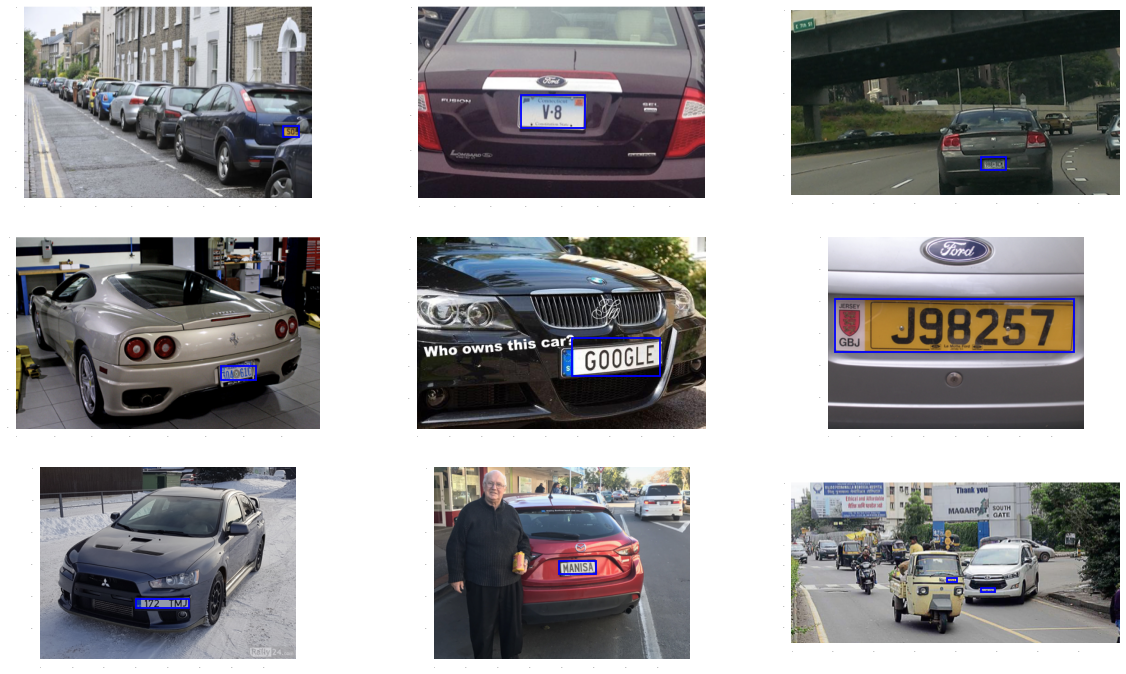

In [ ]:
def plot_detections(images_path, labels_path, detection_path = None, color = 'b'):
  from matplotlib.patches import Rectangle

  fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize=(20, 12))
  predictions = os.listdir(images_path if detection_path is None else detection_path) 

  for i in range(9):
    img = np.asarray(Image.open(images_path + predictions[i]))                  #get car image
    shape = np.array(img.shape)                                                 

    with open(labels_path+predictions[i][:-3]+'txt') as f:                      #get bounding boxes
      lines = f.readlines()

    true_box = np.array([i.split('\t')[1:] for i in lines], dtype=np.float32)*shape[[1, 0, 1, 0]]       #inverse transform normalization
    for b in true_box.astype(np.uint16):
      ax[int(i//3), int(i%3)].add_patch(Rectangle([b[0]-b[2]/2, b[1]-b[3]/2], b[2], b[3],
                                                   fill=False, color = color, linewidth = 1.8 )) #draw bounding boxes
    
    if detection_path is not None:
      img = Image.open(detection_path + predictions[i])
    ax[i//3, i%3].imshow(img)
  
plot_detections('/tmp/License_data/val/images/', '/tmp/License_data/val/labels/', detection_path = None)

<h3 style="text-align: center"> Transfer Learning with Yolov7 </h3>

Once all the data is prepared and pre-processed, we clone the YoloV7 model of Github and download the pre-trained weights. We then train the model following the <a href='https://colab.research.google.com/drive/1X9A8odmK4k6l26NDviiT6dd6TgR-piOa#scrollTo=ovKgrVN8ygdW'>guide</a> provided. Before commencing training a yaml file is created specifying the data directories and data labels. 


In [ ]:
# !git clone https://github.com/WongKinYiu/yolov7

In [ ]:
# !wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7.pt

In [ ]:
data = {'download': '', 'train': '../License/train/images', 'val': './License/val/images', 
        'test': '',  'nc': 1,'names': ['l1']}

with open('data.yml', 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=True)

Now the training process is ran.

In [ ]:
os.chdir('/content/drive/MyDrive/Code/yolov7')
!python train.py --img 640 640 --batch 16 --epochs 50 --data data/license.yaml --weights runs/train/yolov74/weights/best.pt --cfg cfg/training/yolov7.yaml

YOLOR 🚀 v0.1-115-g072f76c torch 1.12.1+cu113 CUDA:0 (Tesla T4, 15109.75MB)

Namespace(adam=False, artifact_alias='latest', batch_size=16, bbox_interval=-1, bucket='', cache_images=False, cfg='cfg/training/yolov7.yaml', data='data/license.yaml', device='', entity=None, epochs=50, evolve=False, exist_ok=False, freeze=[0], global_rank=-1, hyp='data/hyp.scratch.p5.yaml', image_weights=False, img_size=[640, 640], label_smoothing=0.0, linear_lr=False, local_rank=-1, multi_scale=False, name='exp', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/exp10', save_period=-1, single_cls=False, sync_bn=False, total_batch_size=16, upload_dataset=False, v5_metric=False, weights='runs/train/yolov74/weights/best.pt', workers=8, world_size=1)
tensorboard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/
hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmu

<h3 style="text-align: center"> Transfer Learning with YoloV5 </h3>

The training process of YoloV5 is very similar to that of YoloV7.



In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
os.chdir('./yolov5')
!wget https://github.com/ultralytics/yolov5/releases/download/v5.0/yolov5s.pt

In [ ]:
#yaml file

In [ ]:
!python train.py --img 416 --batch 16 --epochs 20 --data data/license.yaml --weights yolov5s.pt --cache


<h3>Performance</h3>

Lets have a look at couple performance indicating charts for both YoloV5 and YoloV7: precision-recall curves and the evolution of various metrics over the training period. Both charts are outputted automatically by the Yolo API, however the evolution charts will be slightly customized using the historic data on the training progress which the API also records.

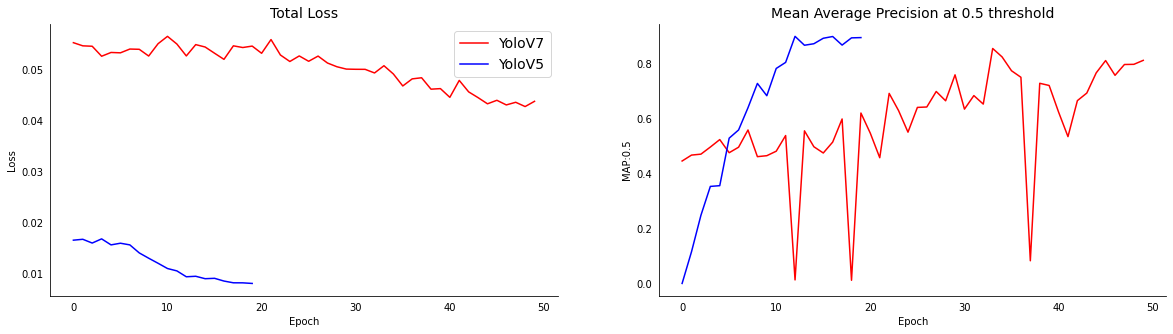

In [ ]:
yolov7_path = '/content/drive/MyDrive/Code/yolov7/runs/train/exp10/'
yolov5_path = '/content/drive/MyDrive/Code/yolov5/runs/train/exp6/'

cols = ['Epoch', 'box', 'obj', 'cls', 'P', 'R', 'mAP@.5', 'mAP@.5:.95', 'val_box', 'val_obj', 'val_cls', 'lr0', 'lr1', 'lr2']
df_yolov5 = pd.read_csv(yolov5_path + 'results.csv', skiprows=[0], names=cols)

cols = ['Epoch', 'gpu_mem', 'box', 'obj', 'cls', 'total', 'targets', 'img_size', 'P', 'R', 'mAP@.5', 'mAP@.5:.95', 'val_box', 'val_obj', 'val_cls']
df_yolov7 = pd.read_csv(yolov7_path + 'results.txt', delimiter='\\s+', header=None, usecols=list(range(14)), names = cols)

fig, ax = plt.subplots(ncols = 2, figsize= (20, 5))
for i in range(2):
  ax[i].tick_params(axis='both', which='major', labelsize=10)      
  ax[i].spines['left'].set_visible(True)
  ax[i].spines['bottom'].set_visible(True)   
ax[0].plot(df_yolov7.index, df_yolov7.total, 'r', label = 'YoloV7')
ax[0].plot(df_yolov5.index, df_yolov5.obj + df_yolov5.cls, 'b', label = 'YoloV5')

ax[1].plot(df_yolov7.index, df_yolov7['mAP@.5'], 'r')
ax[1].plot(df_yolov5.index, df_yolov5['mAP@.5'], 'b')

ax[0].set_xlabel('Epoch')
ax[1].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('MAP:0.5')
ax[0].set_title("Total Loss", fontsize=14)
ax[1].set_title("Mean Average Precision at 0.5 threshold", fontsize=14)
ax[0].legend(fontsize=14)


Text(0.5, 1.0, 'YoloV7')

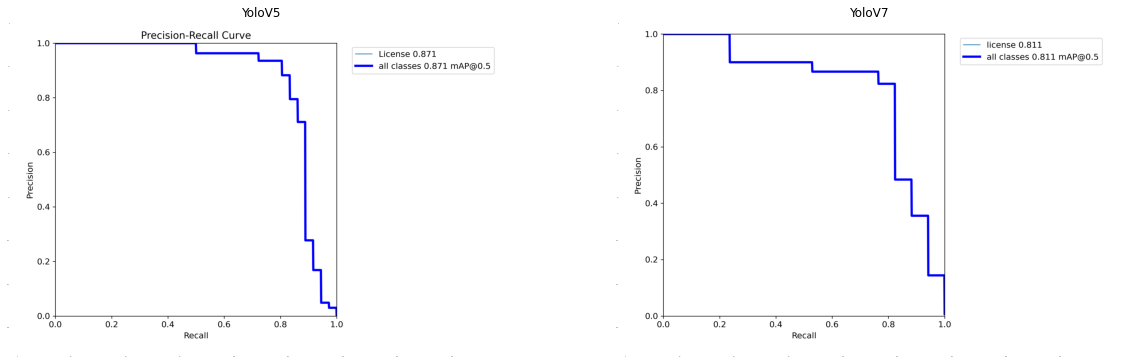

In [ ]:
fig, ax = plt.subplots(ncols = 2, figsize = (20, 6))

ax[0].imshow(Image.open(yolov5_path+'PR_curve.png'))
ax[1].imshow(Image.open(yolov7_path+'PR_curve.png'))

ax[0].set_title('YoloV5')
ax[1].set_title('YoloV7')

<h3 style="text-align: center;"> Predictions </h3>

We will now run predictions on the test set with the better performing model that is YoloV5.


In [ ]:
os.chdir('/content/drive/MyDrive/Code/yolov7/')
!python detect.py --weights runs/train/exp10/weights/best.pt --conf 0.3 --source /tmp/License_data/val/images --save-txt


Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.3, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', no_trace=False, nosave=False, project='runs/detect', save_conf=False, save_txt=True, source='/tmp/License_data/val/images', update=False, view_img=False, weights=['runs/train/exp10/weights/best.pt'])
YOLOR 🚀 v0.1-115-g072f76c torch 1.12.1+cu113 CPU

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
Model Summary: 314 layers, 36481772 parameters, 6194944 gradients
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

/usr/local/lib/python3.8/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
1 license, Done. (1538.8ms) Infere

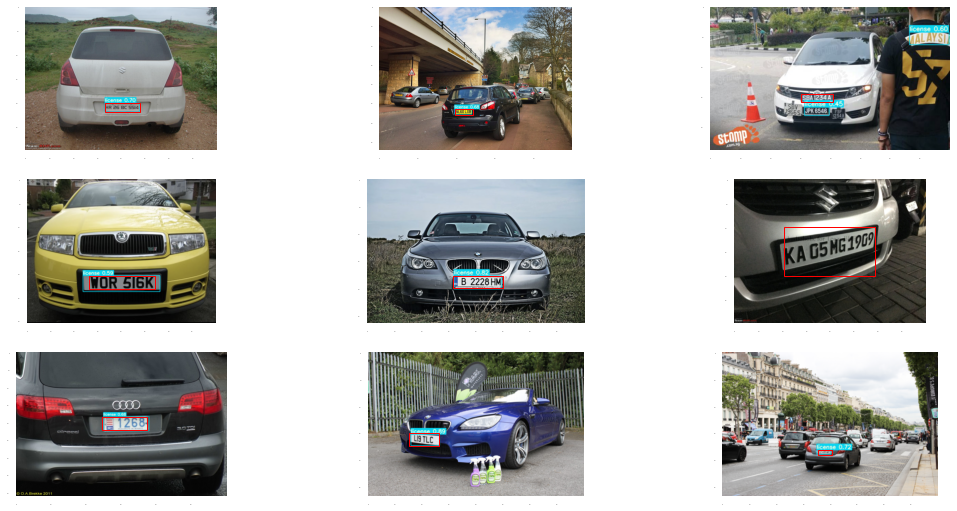

In [ ]:
plot_detections('/tmp/License_data/val/images/', '/tmp/License_data/val/labels/', '/content/drive/MyDrive/Code/yolov7/runs/detect/exp6/', color='r')


<h3 style="text-align: center;"> Character Recognition with EasyOCR </h3>




In [ ]:
def ocr_preprocess(img):
    img = cv2.resize(img, (224, 64), interpolation = cv2.INTER_CUBIC)

    img = cv2.fastNlMeansDenoising(img, h=3) 
    R, G, B = cv2.split(img)
    output1_R = cv2.equalizeHist(R)
    output1_G = cv2.equalizeHist(G)
    output1_B = cv2.equalizeHist(B)
    img = cv2.merge((output1_R, output1_G, output1_B))

    img = cv2.GaussianBlur(img, (5, 5), 1)

    return img


In [ ]:
detection_path = '/content/drive/MyDrive/Code/yolov7/runs/detect/exp8/'

predictions = list( filter(lambda x: x[-3:]=='png',  os.listdir(detection_path)) )

reader = easyocr.Reader(['en'])
readings = dict()

darknet_to_pascal = lambda x: np.array([x[0]-x[2]/2, x[1]-x[3]/2, x[0]+x[2]/2, x[1]+x[3]/2 ], dtype=np.uint16)

for p in predictions:

  img = np.asarray(Image.open(detection_path + p)).copy()
  shape = np.array(img.shape)

  plates = []

  try:
    with open( f"{detection_path}labels/{p[:-3]}txt") as f:
      lines = f.readlines()
    true_box = np.array([i.split(' ')[1:] for i in lines], dtype=np.float16)*shape[[1, 0, 1, 0]]

    for box in true_box:
      box = darknet_to_pascal(box)
      plate_cropped = img[box[1]:box[3], box[0]:box[2], :]
      plate_cropped = ocr_preprocess(plate_cropped)
      plate_number = reader.readtext(plate_cropped, allowlist = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ')
      plates.append( (box, " ".join([char[1] for char in plate_number])) )
  
  except:
    print(f"No license plates detected in {p}")
    pass
  readings[p[:-4]] = [p for p in plates if len(p)>0]



No license plates detected in Cars196.png
No license plates detected in Cars399.png


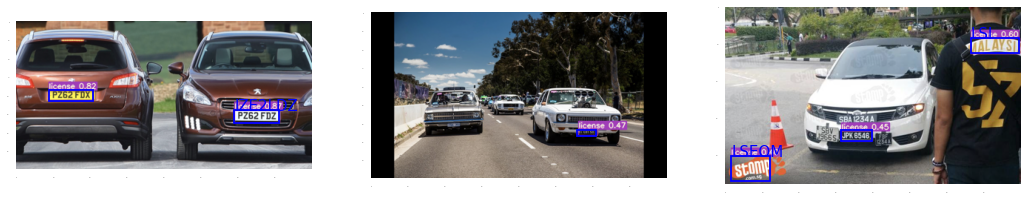

In [ ]:
fig, ax = plt.subplots(ncols = 3, figsize=(18, 9))
detection_path = '/content/drive/MyDrive/Code/yolov7/runs/detect/exp8/'

val_path = '/tmp/License_data/val/images'
val_path = '/content/drive/MyDrive/Code/yolov7/runs/detect/exp8/'
val_images = os.listdir(val_path)[1:]
random.shuffle(val_images)

for i in range(3):
  _file = val_images[i]
  plates = readings[_file[:-4]]

  img = Image.open(val_path+_file)
  ax[i%3].imshow(img)
  for box, number in plates:
    ax[int(i%3)].add_patch(Rectangle([box[0], box[1]], box[2]-box[0], box[3]-box[1],
                                              fill=False, color = 'b', linewidth = 1.8 )) #draw bounding boxes
    ax[int(i%3)].text(box[0], box[1], number, color='y', fontsize = 15, backgroundcolor='b')                                  


